In [1]:
import re

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import dask_geopandas
from collections import OrderedDict

import s3fs
import base64
import json
import os
import requests
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import netCDF4 as nc
from dotenv import load_dotenv
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 1. Setting up Spark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit


# spark = SparkSession.builder.getOrCreate()

# only use 4 corea
spark = SparkSession.builder.master("local[4]").getOrCreate()

In [3]:
spark

In [4]:
spark.sparkContext.defaultParallelism

4

In [5]:
# spark.stop()

# 2. Preparing NO2 Data

For NO2 data, I will be using OMI NO2 from NASA. This dataset is daily-level ar roughly 0.1deg * 0.1deg resolution. OMI instrument present in a satellite orbits the Earth 14 to 15 times a day and calculate NO2 vertical column density. Vertical Column Density or VCD refers to the total amount of NO2 molecules present from earth surface to the top of the atmosphere. NO2 pollution would be in tons that can be calculated from surface concentrations (NO2 molecules present on earth surface). This can be done using ground based sensors from EPA or PANDORA. 

Even though the data I am using is vertical columns, it still is a very good indicator of NO2 pollution. It is satellite-based data, which means we can do global-level data analysis and evaluation. Besides, the presence of sensors is very scarce and it is not possible to place ground-based sensors throughout the world. That's where satellite-based evaluation come in handy.

<b> Higher OMI NO2 VCD indicates more NO2 emissions from burning of fuel (cars), industries, etc. Furthermore, NO2 irritates the airways in our lungs and nose, causing inflammation and swelling, and is one of the top pollutants to cause respiratory disease like Asthma</b>

I wil be using `OMI_MINDS_NO2` dataset from NASA. You can find more about it from the following link: https://disc.gsfc.nasa.gov/datasets/OMI_MINDS_NO2_1.1/summary?keywords=OMI_MINDS_NO2_1.1


This data is also available on S3. I will be reading the files directly from S3. 

In [8]:
load_dotenv()

True

In [9]:
'''
This is how we can fetch temporary credentials from NASA's Earthdata to access AWS S3 bucket.
These expire after 1 hour. And, you need an active earthdata account to get the credentials.
This code is present on NASA's website:

https://archive.podaac.earthdata.nasa.gov/s3credentialsREADME
'''

s3_endpoint = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"
username = os.getenv("EARTHDATA_USERNAME")
password = os.getenv("EARTHDATA_PASSWORD")


login_resp = requests.get(s3_endpoint, allow_redirects=False)
login_resp.raise_for_status()

auth = f"{username}:{password}"
encoded_auth = base64.b64encode(auth.encode('ascii'))

auth_redirect = requests.post(
    login_resp.headers['location'],
    data={"credentials": encoded_auth},
    headers={"Origin": s3_endpoint},
    allow_redirects=False
)
auth_redirect.raise_for_status()

final = requests.get(auth_redirect.headers['location'], allow_redirects=False)
final.raise_for_status()

results = requests.get(s3_endpoint, cookies={'accessToken': final.cookies['accessToken']})
results.raise_for_status()

creds = json.loads(results.content)

In [10]:
# creating s3fs object to access the bucket using the retrieved temporaty credentials
s3_fs = s3fs.S3FileSystem(
        key = creds['accessKeyId'],
        secret = creds['secretAccessKey'],
        token = creds['sessionToken'],
    )

In [11]:
'''
The name of the S3 bucket that contains OMI NO2 data is gesdisc-cumulus-prod-protected.
Let's quickly test if we can connect to the bucket or not.
'''

try:
    files = s3_fs.ls("s3://gesdisc-cumulus-prod-protected")
    print("Connection successful! Files found:")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful! Files found:


We have set up our s3fs object and connected it to NASA's s3 bucket. Next thing will be to go on the NASA GESC DISC website and get the text file containing links to the s3 files for OMI NO2 from 2018 to 2022. The data is present inside `gesdisc-cumulus-prod-protected` bucket.

We can directly stream the data object into our RAM using `Xarray` python library. 

In [12]:
''''
These are the S3 links to OMI NO2 data files from year 2018 to 2022. I got this from NASA's GESC DISC.
You can get these links from the following URL:

https://disc.gsfc.nasa.gov/datasets/OMI_MINDS_NO2_1.1/summary?keywords=OMI_MINDS_NO2_1.1
'''

with open("OMI_NO2_S3_Links.txt", "r") as file:
    omi_no2_links = file.readlines()

omi_no2_links = [line.strip() for line in omi_no2_links]
omi_no2_links = [link for link in omi_no2_links if link.endswith(".nc")]
print("TOTAL NUMBER OF FILES IS: ", len(omi_no2_links))
omi_no2_links[:10]

TOTAL NUMBER OF FILES IS:  9196


['s3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2022/365/OMI-Aura_L2-OMI_MINDS_NO2_2022m1231t2250-o098205_v01-01-2023m0223t193712.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t0029-o098206_v01-01-2023m0223t193641.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1201-o098213_v01-01-2023m0223t193846.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1340-o098214_v01-01-2023m0223t193853.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1519-o098215_v01-01-2023m0223t193844.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101t1658-o098216_v01-01-2023m0223t193916.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2023/001/OMI-Aura_L2-OMI_MINDS_NO2_2023m0101

Each file is roughly ~10mb in size (some can be larger and some can be smaller). With 23084 files, the total data size that we will be streaming will be ~250 GB. However, these files contain global data and we will filter data only for the US bounding cordinates. 

In [13]:
def is_over_us_state(lat: np.array, lon: np.array):
    """Returns True if (lat, lon) is inside any of the 50 US states (excluding territories)."""
    
    # Continental U.S. (CON 48 states)
    conus = (
        (24.5 <= lat <= 49.5) &  
        (-125.0 <= lon <= -66.95)  
    )
    
    # Alaska 
    alaska = (
        (51.0 <= lat <= 71.4) &  
        ((-170.0 <= lon <= -129.9)) 
    )
    
    # Hawaii
    hawaii = (
        (17.9 <= lat <= 26) &  
        (-162.0 <= lon <= -154.5)  
    )
    
    return conus | alaska | hawaii


In [9]:
global_latitude = []
global_longitude = []
global_ColumnAmountNO2 = []
global_cloudFraction = []
global_LAT1 = []
global_LAT2 = []
global_LAT3 = []
global_LAT4 = []
global_LON1 = []
global_LON2 = []
global_LON3 = []
global_LON4 = []
global_date = []

for current_file in tqdm(omi_no2_links[:30]):
    with s3_fs.open(current_file, mode="rb") as f:
        dataset = nc.Dataset("in-memory.nc", memory=f.read())

    filename = os.path.basename(current_file)
    date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
    ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
    cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
    latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
    longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
    corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
    corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
    LAT1 = corner_latitude[:, 0]
    LAT2 = corner_latitude[:, 1]
    LAT3 = corner_latitude[:, 2]
    LAT4 = corner_latitude[:, 3]
    LON1 = corner_longitude[:, 0]
    LON2 = corner_longitude[:, 1]
    LON3 = corner_longitude[:, 2]
    LON4 = corner_longitude[:, 3]
    date = np.repeat(date, ColumnAmountNO2.shape[0])

    boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])

    ColumnAmountNO2 = ColumnAmountNO2[boolean_mask]
    cloudFraction = cloudFraction[boolean_mask]
    latitude = latitude[boolean_mask]
    longitude = longitude[boolean_mask]
    LAT1 = LAT1[boolean_mask]
    LAT2 = LAT2[boolean_mask]
    LAT3 = LAT3[boolean_mask]
    LAT4 = LAT4[boolean_mask]
    LON1 = LON1[boolean_mask]
    LON2 = LON2[boolean_mask]
    LON3 = LON3[boolean_mask]
    LON4 = LON4[boolean_mask]
    date = date[boolean_mask]

    global_latitude.extend(latitude)
    global_longitude.extend(longitude)
    global_ColumnAmountNO2.extend(ColumnAmountNO2)
    global_cloudFraction.extend(cloudFraction)
    global_LAT1.extend(LAT1)
    global_LAT2.extend(LAT2)
    global_LAT3.extend(LAT3)
    global_LAT4.extend(LAT4)
    global_LON1.extend(LON1)
    global_LON2.extend(LON2)
    global_LON3.extend(LON3)
    global_LON4.extend(LON4)
    global_date.extend(date)

    dataset.close()

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:11<00:00,  2.52it/s]


In [10]:
global_latitude = np.array(global_latitude)
global_longitude = np.array(global_longitude)
global_ColumnAmountNO2 = np.array(global_ColumnAmountNO2)
global_cloudFraction = np.array(global_cloudFraction)
global_LAT1 = np.array(global_LAT1)
global_LAT2 = np.array(global_LAT2)
global_LAT3 = np.array(global_LAT3)
global_LAT4 = np.array(global_LAT4)
global_LON1 = np.array(global_LON1)
global_LON2 = np.array(global_LON2)
global_LON3 = np.array(global_LON3)
global_LON4 = np.array(global_LON4)
global_date = np.array(global_date)

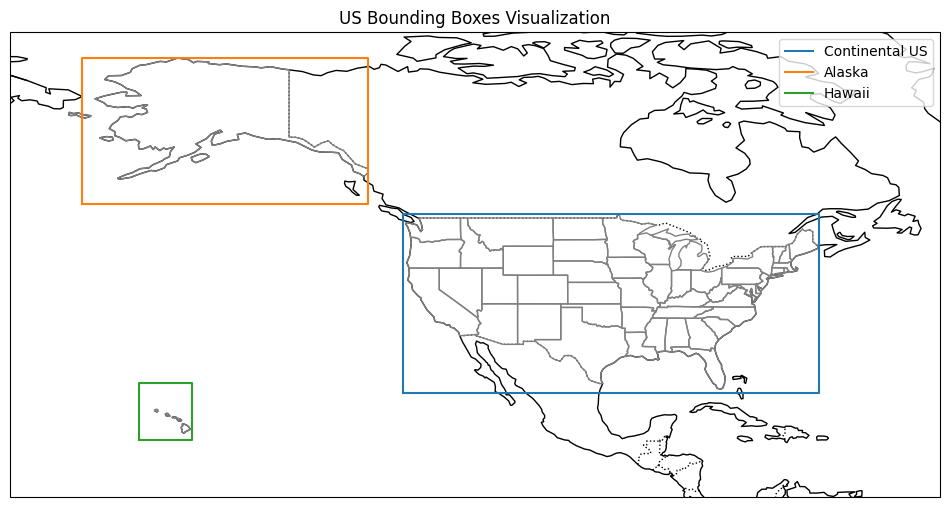

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-180, -50, 10, 75], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='gray')

bounding_boxes = {
    "Continental US": [[24.5, 49.5], [-125.0, -66.95]],
    "Alaska": [[51.0, 71.4], [-170.0, -129.9]], 
    "Hawaii": [[17.9, 26], [-162.0, -154.5]]
}

for region, ((lat_min, lat_max), (lon_min, lon_max)) in bounding_boxes.items():
    lats = [lat_min, lat_max, lat_max, lat_min, lat_min]
    lons = [lon_min, lon_min, lon_max, lon_max, lon_min]
    ax.plot(lons, lats, transform=ccrs.PlateCarree(), label=region)

ax.legend()
plt.title("US Bounding Boxes Visualization")
plt.show()


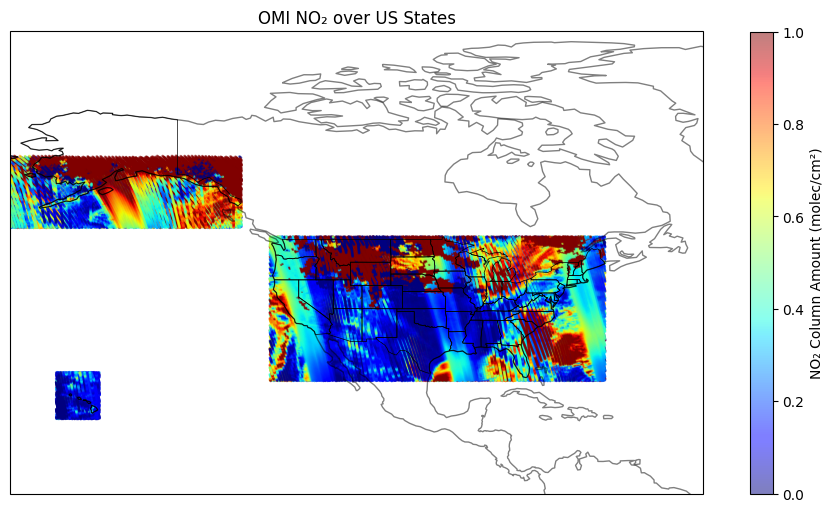

In [12]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-170, -50, 5, 85], crs=ccrs.PlateCarree()) 
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, alpha=0.5)
scatter = ax.scatter(global_longitude, global_latitude, c=global_cloudFraction, s=1, cmap='jet', transform=ccrs.PlateCarree(), alpha=0.5)
plt.colorbar(scatter, label='NO₂ Column Amount (molec/cm²)', orientation='vertical')
plt.title('OMI NO₂ over US States')
plt.show()

Perfect. Our bounding box and data filtration logic is valid. Lets process data files one month at a time and export them to not run out of memory.

In [8]:
import random

random.sample(omi_no2_links, 10)

['s3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/042/OMI-Aura_L2-OMI_MINDS_NO2_2020m0211t1604-o082852_v01-01-2022m0210t053236.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/038/OMI-Aura_L2-OMI_MINDS_NO2_2020m0207t1131-o082791_v01-01-2022m0210t052904.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2021/207/OMI-Aura_L2-OMI_MINDS_NO2_2021m0726t1505-o090584_v01-01-2022m0210t121032.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2021/306/OMI-Aura_L2-OMI_MINDS_NO2_2021m1102t2202-o092030_v01-01-2022m0210t134302.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2019/111/OMI-Aura_L2-OMI_MINDS_NO2_2019m0421t1205-o078539_v01-01-2022m0210t024711.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2020/132/OMI-Aura_L2-OMI_MINDS_NO2_2020m0511t1830-o084164_v01-01-2022m0210t062259.nc',
 's3://gesdisc-cumulus-prod-protected/MINDS/OMI_MINDS_NO2.1.1/2018/290/OMI-Aura_L2-OMI_MINDS_NO2_2018m1017

In [14]:

def get_s3links_for_selected_date(year: str, month:str) -> list[str]:
    """
    Get the S3 links for a specific year and month.
    """
    month_str = f"{int(month):02d}"
    pattern = re.compile(rf'.*OMI_MINDS_NO2_{year}m{month_str}\d{{2}}t\d{{4}}.*\.nc$')
    files = sorted([file for file in omi_no2_links if pattern.search(file)])
    return files

In [15]:
def process_data_monthly(year: str, month: str):
    '''
    Read the OMI NO2 data files for a specific month and year from S3 bucket and export it.
    '''
    try:
        omi_no2_links_for_selected_YYYYMM = get_s3links_for_selected_date(year, month)
        
        dfs = []

        for current_file in tqdm(omi_no2_links_for_selected_YYYYMM):
            try:
                with s3_fs.open(current_file, mode="rb") as f:
                    with nc.Dataset("in-memory.nc", memory=f.read()) as dataset:
                        filename = os.path.basename(current_file)
                        date = filename.split("OMI-Aura_L2-OMI_MINDS_NO2_")[1][:9]
                        
                        # Extract data
                        ColumnAmountNO2 = dataset.groups["SCIENCE_DATA"]["ColumnAmountNO2"][:].filled(np.nan).reshape(-1)
                        cloudFraction = dataset.groups["ANCILLARY_DATA"]["CloudFraction"][:].filled(np.nan).reshape(-1)
                        latitude = dataset.groups["GEOLOCATION_DATA"]["Latitude"][:].filled(np.nan).reshape(-1)
                        longitude = dataset.groups["GEOLOCATION_DATA"]["Longitude"][:].filled(np.nan).reshape(-1)
                        corner_latitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLatitude"][:].reshape(-1, 4)
                        corner_longitude = dataset.groups["GEOLOCATION_DATA"]["FoV75CornerLongitude"][:].reshape(-1, 4)
                        
                        # Create boolean mask
                        boolean_mask = np.array([is_over_us_state(lat, lon) for lat, lon in zip(latitude, longitude)])
                        
                        # Filter data
                        filtered_data = {
                            "latitude": latitude[boolean_mask],
                            "longitude": longitude[boolean_mask],
                            "ColumnAmountNO2": ColumnAmountNO2[boolean_mask],
                            "cloudFraction": cloudFraction[boolean_mask],
                            "LAT1": corner_latitude[:, 0][boolean_mask],
                            "LAT2": corner_latitude[:, 1][boolean_mask],
                            "LAT3": corner_latitude[:, 2][boolean_mask],
                            "LAT4": corner_latitude[:, 3][boolean_mask],
                            "LON1": corner_longitude[:, 0][boolean_mask],
                            "LON2": corner_longitude[:, 1][boolean_mask],
                            "LON3": corner_longitude[:, 2][boolean_mask],
                            "LON4": corner_longitude[:, 3][boolean_mask],
                            "date": np.repeat(date, np.sum(boolean_mask))
                        }
                        
                        dfs.append(pd.DataFrame(filtered_data))
            
            except Exception as e:
                print(f"Error processing file {current_file}: {str(e)}")
                continue

        if dfs:
            final_df = pd.concat(dfs, ignore_index=True)
            output_path = f"omi_no2_data_{year}_{month}.parquet"
            final_df.dropna(inplace=True)
            final_df.reset_index(drop=True, inplace=True)
            final_df.to_parquet(output_path)
        else:
            print("No valid data processed for the given month.")

        return True 
    except Exception as e:
        print(f"Error processing data for {year}-{month}: {str(e)}")
        return False

In [16]:
from joblib import Parallel, delayed

It is taking roughly 3 minutes to process one month of data. Therefore, I will utilize joblib to parallize this process. This way, I can process data for multiple months simultaneously to reduce the total processing time. Each daily file is ~10 MB and reading though them, filtering exporting month file takes some time. Each exported monthly file is ~30MB.

In [17]:
def proces_data_in_parallel(year_selected: str, num_cores= 6):
    """
    This function will process multiple months in parallel for a given year
    """
    months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    Parallel(n_jobs=num_cores)(delayed(process_data_monthly)(year, month) for year in [year_selected] for month in months)

In [ ]:
proces_data_in_parallel("2018")
proces_data_in_parallel("2019")
proces_data_in_parallel("2020")

In [13]:
proces_data_in_parallel("2020")

100%|██████████| 414/414 [04:32<00:00,  1.52it/s]


In [14]:
proces_data_in_parallel("2021")

100%|██████████| 432/432 [04:38<00:00,  1.55it/s]


In [15]:
proces_data_in_parallel("2022")

100%|██████████| 409/409 [03:55<00:00,  1.73it/s]


In [18]:
proces_data_in_parallel("2023")

100%|██████████| 428/428 [04:22<00:00,  1.63it/s]


In [19]:
proces_data_in_parallel("2024")

100%|██████████| 416/416 [04:50<00:00,  1.43it/s]


# 3. NO2 Pollution Analysis

In [6]:
files_path = "Data/NO2/Single_Files"
files = os.listdir(files_path)
files = [os.path.join(files_path, file) for file in files if file.endswith(".parquet")]
files = sorted(files)

In [7]:
len(files), files[0], files[-1]

(84,
 'Data/NO2/Single_Files\\omi_no2_data_2018_01.parquet',
 'Data/NO2/Single_Files\\omi_no2_data_2024_12.parquet')

If we look here, each parquet file is the NO2 data for US for each month (daily of course). We will read each parquet file into spark data frame and concat them.

In [8]:
no2_df = spark.read.parquet(files[0])

In [9]:
no2_df.show(10)

+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| latitude| longitude|ColumnAmountNO2|     cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|     date|
+---------+----------+---------------+------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| 40.26102|  -66.9704|  2.14097046E15|             0.706|39.8134|40.4608|40.6886|40.0696|-67.7036|-66.0866|-66.2213|-67.8613|2018m0101|
| 40.37128| -67.03718|  2.49873493E15|             0.737|39.9231|40.5719|40.7996|40.1791|-67.7709|-66.1521|-66.2873|-67.9292|2018m0101|
|40.481525|-67.104126|  2.08931852E15|             0.739|40.0328|40.6829|40.9105|40.2886|-67.8385|-66.2179|-66.3535|-67.9971|2018m0101|
|40.591774| -67.17118|  1.86005531E15|             0.717|40.1422|40.7938|41.0213| 40.398|-67.9063|-66.2838|-66.4199|-68.0655|2018m0101|
|  40.7019|-67.238594|  2.01618274E15|0.69600000

Here, latitude, longitude and their corner cordinates are geographical information that can be used to perform spatial analysis. ColumnAmountNO2 is the OMI NO2 vertical column density whereas cloudFraction refers to the percentage/fraction of sky covered with clouds at the specific cordinates. If the value of cloud fraction is large, the OMI instrument's NO2 column values will not be accurate as cloud reflects sunlight and the measurement become inaacurate. Therefore, we will later only use data where cloud fraction is less than 0.5. The higher the threshold we set, the more data we loose. 

In [10]:
no2_df

DataFrame[latitude: float, longitude: float, ColumnAmountNO2: float, cloudFraction: double, LAT1: float, LAT2: float, LAT3: float, LAT4: float, LON1: float, LON2: float, LON3: float, LON4: float, date: string]

In [11]:
min_lat = 35
max_lat = 42
min_lon = -80
max_lon = -70.5

import geopandas as gpd
from shapely.geometry import Polygon

bounding_box = Polygon([(min_lon, min_lat), (max_lon, min_lat), (max_lon, max_lat), (min_lon, max_lat)])
bounding_box = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[bounding_box])

In [12]:
from pyspark.sql.functions import col

In [13]:
# no2_df = no2_df.filter((col("latitude") >= min_lat) & (col("latitude") <= max_lat) & (col("longitude") >= min_lon) & (col("longitude") <= max_lon))
# no2_df = no2_df.filter(
#     (col("longitude") >= min_lon) & 
#     (col("longitude") <= max_lon) & 
#     (col("latitude") >= min_lat) & 
#     (col("latitude") <= max_lat)
# )

In [14]:
# no2_df = no2_df.toPandas()

In [15]:
# no2_df["geometry"] = gpd.points_from_xy(no2_df["longitude"], no2_df["latitude"])
# no2_df = gpd.GeoDataFrame(no2_df, geometry="geometry", crs="EPSG:4326")

In [16]:
maryland = gpd.read_file(r'Data\US_SHAPEFILES\State_Boundary\us-state-boundaries.shp')
maryland = maryland[maryland.name == 'Maryland'][["geometry"]].reset_index(drop=True)

us_states = gpd.read_file(r'Data\US_SHAPEFILES\State_Boundary\us-state-boundaries.shp')
us_states = us_states[["name", "geometry"]]

In [17]:
import geopandas as gpd
from shapely.geometry import Point

cities = {
    "Baltimore": (39.2904, -76.6122),
    "Philadelphia": (39.9526, -75.1652),
    "Washington, D.C.": (38.9072, -77.0369),
    "Richmond": (37.5407, -77.4360),
    "New York City": (40.7128, -74.0060)
}

geometry = [Point(lon, lat) for lat, lon in cities.values()]
city_names = list(cities.keys())
major_cities_points = gpd.GeoDataFrame({"City": city_names}, geometry=geometry, crs="EPSG:4326")

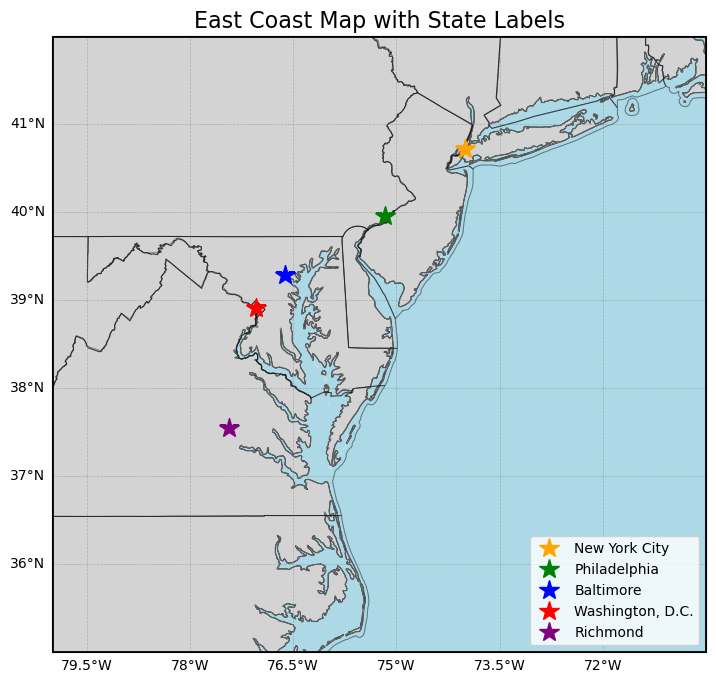

In [18]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot Maryland boundary
us_states.geometry.boundary.plot(ax=ax, color='black', linewidth=0.75, alpha=0.45, transform=ccrs.PlateCarree())
bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())

colors = ['blue', 'green', 'red', 'purple', 'orange']
for color, (idx, row) in zip(colors, major_cities_points.iterrows()):
    ax.plot(row.geometry.x, row.geometry.y, marker='*', markersize=15, color=color, alpha=1,
            transform=ccrs.PlateCarree())

from matplotlib.lines import Line2D
city_handles = [
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='orange',
              markeredgecolor='orange', label='New York City', markersize=15),

    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='green',
           markeredgecolor='green', label='Philadelphia', markersize=15),
        
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='blue',
           markeredgecolor='blue', label='Baltimore', markersize=15),
    
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='red',
           markeredgecolor='red', label='Washington, D.C.', markersize=15),
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='purple',
           markeredgecolor='purple', label='Richmond', markersize=15),

]
ax.legend(handles=city_handles, loc='lower right', fontsize=10, frameon=True)
plt.title("East Coast Map with State Labels", fontsize=16)
plt.show()

In [19]:
df = spark.read.parquet(files[0])
df = df.filter(
    (col("longitude") >= min_lon) & 
    (col("longitude") <= max_lon) & 
    (col("latitude") >= min_lat) & 
    (col("latitude") <= max_lat) &
    (col("ColumnAmountNO2") > 0) &
    (col("cloudFraction") < 0.3) 
)

In [20]:
for file in tqdm(files[1:]):
    try:
        no2_df = spark.read.parquet(file)
        no2_df = no2_df.filter(
            (col("longitude") >= min_lon) & 
            (col("longitude") <= max_lon) & 
            (col("latitude") >= min_lat) & 
            (col("latitude") <= max_lat) &
            (col("ColumnAmountNO2") > 0) &
            (col("cloudFraction") < 0.3) 
        )
        
        df = df.union(no2_df)
    except Exception as e:
        print(f"Error processing file {file}: {str(e)}")
        continue

100%|██████████| 83/83 [00:07<00:00, 10.47it/s]


In [21]:
df.show(10)

+---------+----------+---------------+-------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
| latitude| longitude|ColumnAmountNO2|      cloudFraction|   LAT1|   LAT2|   LAT3|   LAT4|    LON1|    LON2|    LON3|    LON4|     date|
+---------+----------+---------------+-------------------+-------+-------+-------+-------+--------+--------+--------+--------+---------+
|35.054005|-76.120094|  3.56455335E15|              0.185|34.9601|35.0182| 35.147|35.0897|-76.2421|-75.9567|-75.9976|-76.2837|2018m0101|
|35.050556|-76.746704|   6.2522091E15|              0.123|34.9518|35.0175|35.1481|35.0836|-76.8763| -76.574|-76.6165|-76.9198|2018m0101|
|35.113728| -76.44831|   5.0609135E15|               0.17|35.0175|35.0793|35.2089|35.1481| -76.574|-76.2804|-76.3222|-76.6165|2018m0101|
|35.173218| -76.15825|  1.28521434E15|0.14200000000000002|35.0793|35.1374|35.2662|35.2089|-76.2804|-75.9946|-76.0357|-76.3222|2018m0101|
|35.030117| -77.41357|  2.62649383E15|0.1

In [22]:
# df.count()

In [23]:
# from pyspark.sql.functions import to_date, regexp_replace

# # Fix date format from "2018m0101" to "20180101" then to date
# df = df.withColumn("date", to_date(regexp_replace("date", "m", ""), "yyyyMMdd"))

In [24]:
# from pyspark.sql.functions import year, month, dayofmonth, date_format

# df = df.withColumn("year", year("date")) \
#        .withColumn("month", month("date")) \
#        .withColumn("day", dayofmonth("date")) \
#        .withColumn("dayname", date_format("date", "EEEE"))


In [25]:
# df = df.withColumn("year_month", date_format("date", "yyyy-MM"))
# df.show(10)

In [26]:
# from pyspark.sql.functions import avg

# monthly_avg_df = df.groupBy("year_month").agg(avg("ColumnAmountNO2").alias("avg_NO2"))

In [27]:
# monthly_avg_df = monthly_avg_df.toPandas()
# monthly_avg_df

In [28]:
# import seaborn as sns
# import matplotlib.dates as mdates

# # Convert year_month to datetime for better handling
# monthly_avg_df["year_month"] = pd.to_datetime(monthly_avg_df["year_month"])

# # Create the plot
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=monthly_avg_df, x="year_month", y="avg_NO2", marker="o")
# plt.xticks(rotation=45)
# plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show ticks for each year
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as YYYY
# plt.title("Monthly Average NO₂ Levels Over Time")
# plt.xlabel("Year")
# plt.ylabel("Average NO₂ (molec/cm²)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [29]:
df = df.toPandas()

In [30]:
import shapely

def create_fishnet(polygon, width_degree, height_degree):
    xmin, ymin, xmax, ymax = polygon.total_bounds
    cell_width  = width_degree
    cell_height = height_degree
    grid_cells = []
    
    ''' CREATING PIXELS/GRIDS AROUND THE POLYGON '''
    for x0 in tqdm(np.arange(xmin, xmax+cell_width, cell_width )):
        for y0 in np.arange(ymin, ymax+cell_height, cell_height):
            x1 = x0-cell_width
            y1 = y0+cell_height
            new_cell = shapely.geometry.box(x0, y0, x1, y1)
            grid_cells.append(new_cell)
            
    fishnet_x = gpd.GeoDataFrame({'geometry':grid_cells}).set_geometry('geometry').set_crs('EPSG:4326')
    fishnet_x = fishnet_x[['geometry']]
    
    ''' ONLY SELECTING THE CREATED PIXELS THAT INERSECT WITH THE ORIGINAL POLYGON '''
    fishnet_dask = dask_geopandas.from_geopandas(fishnet_x, npartitions=12)
    fishnet_x = dask_geopandas.sjoin(fishnet_dask, polygon, predicate = 'intersects').compute()
    fishnet_x = fishnet_x[['geometry']].reset_index(drop = True)
    
    
    ''' CLIPPING THE PIXELS THAT OVERLAP THE POLYGON TO THE AREA INSIDE THE POLYGON '''
    fishnet_dask = dask_geopandas.from_geopandas(fishnet_x, npartitions=12)
    fishnet_x = dask_geopandas.clip(fishnet_dask, polygon, keep_geom_type = True).compute()
    fishnet_x = fishnet_x[['geometry']].reset_index(drop = True)
    
    return fishnet_x

fishnet_x = create_fishnet(bounding_box, 0.1, 0.1)
fishnet_x["ID"] =  range(1, len(fishnet_x) + 1)

100%|██████████| 96/96 [00:00<00:00, 574.85it/s]


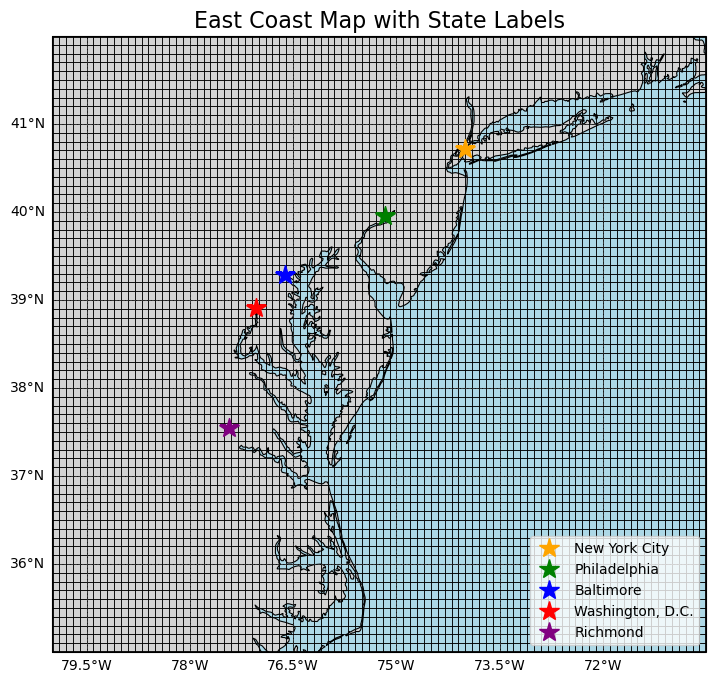

In [31]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

fishnet_x.geometry.boundary.plot(ax=ax, color = "black", alpha = 1, linewidth = 0.5, edgecolor = "black")
bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())

colors = ['blue', 'green', 'red', 'purple', 'orange']
for color, (idx, row) in zip(colors, major_cities_points.iterrows()):
    ax.plot(row.geometry.x, row.geometry.y, marker='*', markersize=15, color=color, alpha=1,
            transform=ccrs.PlateCarree())

from matplotlib.lines import Line2D
city_handles = [
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='orange',
              markeredgecolor='orange', label='New York City', markersize=15),

    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='green',
           markeredgecolor='green', label='Philadelphia', markersize=15),
        
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='blue',
           markeredgecolor='blue', label='Baltimore', markersize=15),
    
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='red',
           markeredgecolor='red', label='Washington, D.C.', markersize=15),
    Line2D([0], [0], marker='*', linestyle='None', markerfacecolor='purple',
           markeredgecolor='purple', label='Richmond', markersize=15),

]
ax.legend(handles=city_handles, loc='lower right', fontsize=10, frameon=True)
plt.title("East Coast Map with State Labels", fontsize=16)
plt.show()

## 3.1 Covid-19 NO2 Pollution Trend Analysis

In [32]:
from shapely import Polygon

def get_polygon(row):
    return Polygon([(row['LON1'], row['LAT1']), (row['LON2'], row['LAT2']),(row['LON3'], row['LAT3']), (row['LON4'], row['LAT4'])])

In [33]:
from tqdm.notebook import tqdm
tqdm.pandas()

df['rectangle'] = df.progress_apply(get_polygon, axis = 1)
df = gpd.GeoDataFrame(df, geometry="rectangle", crs="EPSG:4326")

  0%|          | 0/933312 [00:00<?, ?it/s]

In [34]:
df["date_clean"] = pd.to_datetime(df["date"].str.replace("m", ""), format="%Y%m%d")

# Extract components
df["year"] = df["date_clean"].dt.year
df["month"] = df["date_clean"].dt.month
df["day"] = df["date_clean"].dt.day
df["year_month"] = df["date_clean"].dt.to_period("M").astype(str)
df["day_name"] = df["date_clean"].dt.day_name()

In [35]:
df1 = df[["date_clean", "year", "month", "day", "year_month", "day_name", "rectangle", "ColumnAmountNO2"]].copy()
df1.head()

,date_clean,year,month,day,year_month,day_name,rectangle,ColumnAmountNO2
0,2018-01-01,2018,1,1,2018-01,Monday,"POLYGON ((-76.2421 34.9601, -75.9567 35.0182, ...",3.564553e+15
1,2018-01-01,2018,1,1,2018-01,Monday,"POLYGON ((-76.8763 34.9518, -76.574 35.0175, -...",6.252209e+15
2,2018-01-01,2018,1,1,2018-01,Monday,"POLYGON ((-76.574 35.0175, -76.2804 35.0793, -...",5.060914e+15
3,2018-01-01,2018,1,1,2018-01,Monday,"POLYGON ((-76.2804 35.0793, -75.9946 35.1374, ...",1.285214e+15
4,2018-01-01,2018,1,1,2018-01,Monday,"POLYGON ((-77.5533 34.9252, -77.2286 35.0005, ...",2.626494e+15


In [36]:
df.shape

(933312, 20)

In [37]:
from collections import OrderedDict
def get_ordered_dict(dx, IDs):
    for id_ in IDs:
        if id_ not in dx.keys():
            dx[id_] = np.nan
    
    dict1 = dict(OrderedDict(sorted(dx.items())))
    return np.array(list(dict1.values()))

In [38]:
%%time

local_data = df1[df1.year==2019].copy()
local_data = local_data[(local_data["date_clean"] >= "2019-03-17") & (local_data["date_clean"] <= "2019-05-29")]
result = fishnet_x.sjoin(local_data, predicate = 'intersects')
fishnet_x["NO2_2019"]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet_x['ID'])

CPU times: total: 406 ms
Wall time: 881 ms


In [39]:
%%time

local_data = df1[df1.year==2020].copy()
local_data = local_data[(local_data["date_clean"] >= "2020-03-17") & (local_data["date_clean"] <= "2020-05-29")]
result = fishnet_x.sjoin(local_data, predicate = 'intersects')
fishnet_x["NO2_2020"]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet_x['ID'])

CPU times: total: 391 ms
Wall time: 807 ms


In [40]:
%%time

local_data = df1[df1.year==2021].copy()
local_data = local_data[(local_data["date_clean"] >= "2021-03-17") & (local_data["date_clean"] <= "2021-05-29")]
result = fishnet_x.sjoin(local_data, predicate = 'intersects')
fishnet_x["NO2_2021"]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet_x['ID'])

CPU times: total: 234 ms
Wall time: 989 ms


0it [00:00, ?it/s]

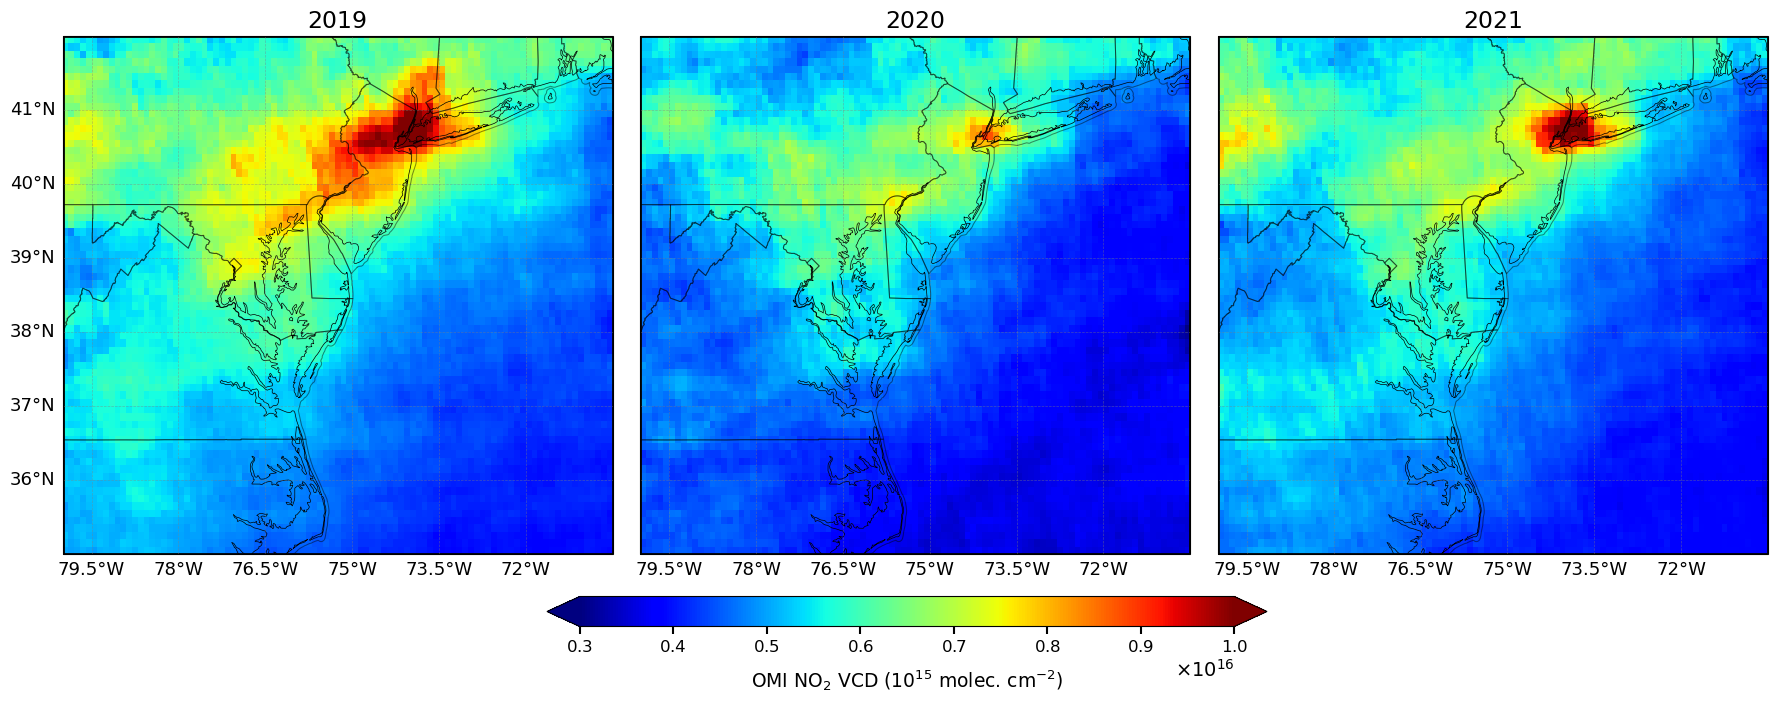

In [41]:
vmin = 3e+15
vmax = 10e+15
cmap = "jet"
alpha = 1

plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, figsize=(18, 6), 
                        subplot_kw={"projection": ccrs.PlateCarree()},
                        gridspec_kw={'width_ratios': [1, 1, 1]})

years = ['2019', '2020', '2021']
columns = ['NO2_2019', 'NO2_2020', 'NO2_2021']
current_col = 0

for ax, year, col in tqdm(zip(axes, years, columns)):
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    # ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    if current_col != 0:
        gl.left_labels = False
    
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    
    bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())
    us_states.geometry.boundary.plot(ax=ax, color='black', linewidth=0.75, alpha=0.45, transform=ccrs.PlateCarree())

    fishnet_x.plot(ax=ax, column=col, alpha=alpha, linewidth=0, edgecolor=None, cmap=cmap,
                   missing_kwds=dict(color='grey', label='No Data'), vmin=vmin, vmax=vmax, legend=False)
    
    ax.set_title(year, fontsize=17)

    ax.tick_params(labelsize=20)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2) 
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=6)
    ax.tick_params(which = 'both', direction = 'in')
    current_col += 1

cax = fig.add_axes([0.31, -0.02, 0.4, 0.05])  
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('OMI NO$_2$ VCD ($10^{15}$ molec. $\mathregular{cm^{-2}}$)', 
               fontsize=13.5, labelpad=10, fontweight='normal')
cbar.ax.tick_params(length=5, width=1.5, which="major", direction='out', labelsize=12)
cbar.set_alpha(alpha)
cbar.draw_all()
cbar.formatter.set_useMathText(True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, hspace=0.1, wspace=0.05)  
plt.show()  

In [42]:
fishnet_x["percentage_change_2019_2020"] = ((fishnet_x["NO2_2020"] - fishnet_x["NO2_2019"]) / fishnet_x["NO2_2019"]) * 100
fishnet_x["percentage_change_2020_2021"] = ((fishnet_x["NO2_2021"] - fishnet_x["NO2_2020"]) / fishnet_x["NO2_2020"]) * 100

In [43]:
fishnet_x.describe()[["percentage_change_2019_2020", "percentage_change_2020_2021"]]

,percentage_change_2019_2020,percentage_change_2020_2021
count,6650.000000,6650.000000
mean,-13.902016,8.925233
std,5.616765,7.200694
min,-38.124794,-17.343792
25%,-17.153836,4.272702
50%,-13.986216,8.688256
75%,-10.246942,13.533429
max,8.530581,47.721951


0it [00:00, ?it/s]

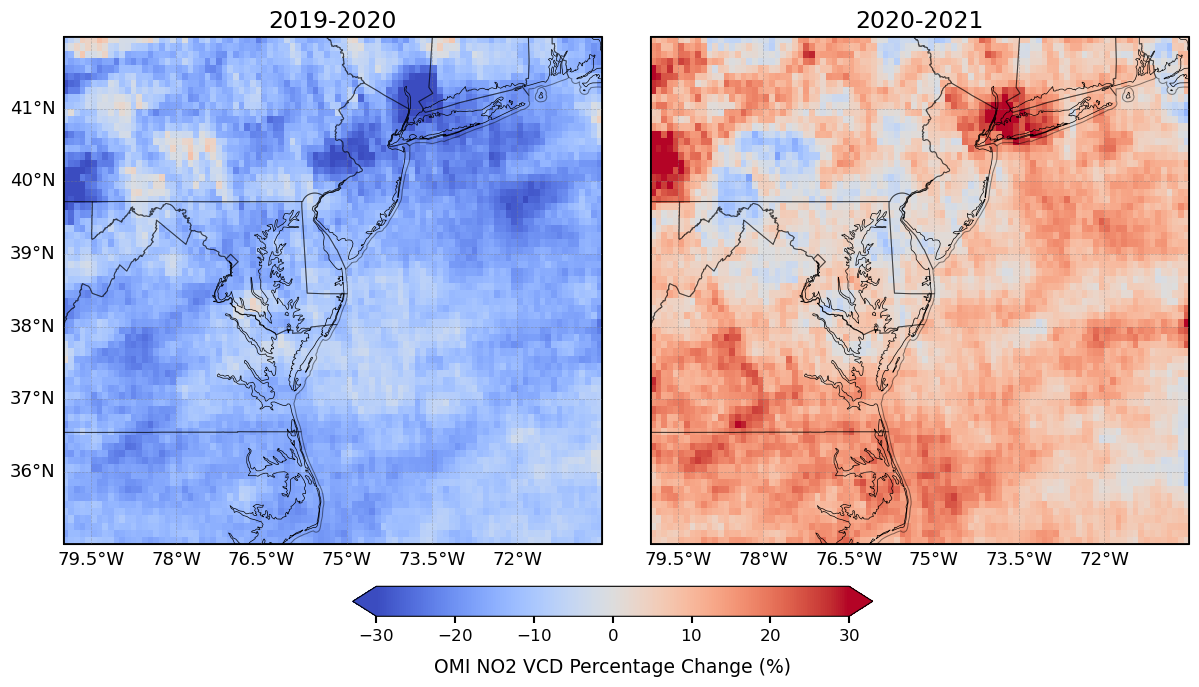

In [44]:
vmin = -30
vmax = 30
cmap = "coolwarm"
alpha = 1

plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 2, figsize=(13, 6), 
                        subplot_kw={"projection": ccrs.PlateCarree()},
                        gridspec_kw={'width_ratios': [1, 1]})

years = ["2019-2020", "2020-2021"]
columns = ['percentage_change_2019_2020', 'percentage_change_2020_2021']
current_col = 0

for ax, year, col in tqdm(zip(axes, years, columns)):
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    if current_col != 0:
        gl.left_labels = False
    
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    
    bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())
    us_states.geometry.boundary.plot(ax=ax, color='black', linewidth=0.75, alpha=0.45, transform=ccrs.PlateCarree())

    fishnet_x.plot(ax=ax, column=col, alpha=alpha, linewidth=0, edgecolor=None, cmap=cmap,
                   missing_kwds=dict(color='grey', label='No Data'), vmin=vmin, vmax=vmax, legend=False)
    
    ax.set_title(year, fontsize=17)

    ax.tick_params(labelsize=20)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2) 
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=6)
    ax.tick_params(which = 'both', direction = 'in')
    current_col += 1

cax = fig.add_axes([0.31, -0.02, 0.4, 0.05])  
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', extend='both')
cbar.set_label('OMI NO2 VCD Percentage Change (%)', 
               fontsize=13.5, labelpad=10, fontweight='normal')
cbar.ax.tick_params(length=5, width=1.5, which="major", direction='out', labelsize=12)
cbar.set_alpha(alpha)
cbar.draw_all()
cbar.formatter.set_useMathText(True)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, hspace=0.1, wspace=-0.05)  
plt.show()  

In [45]:
import osmnx as ox

cities = ["Baltimore, Maryland, USA", 
          "Richmond, Virginia, USA", 
          "Philadelphia, Pennsylvania, USA", 
          "New York City, New York, USA", 
          "Washington, D.C., USA"]

city_geometries = []
for city in cities:
    city_name = city.split(",")[0]
    city_geometries.append(ox.geocode_to_gdf(city)["geometry"].values[0])

city_geometries = gpd.GeoDataFrame({"City": cities}, geometry=city_geometries, crs="EPSG:4326")

In [46]:
city_geometries["City"] = city_geometries["City"].str.split(",").str[0]

In [47]:
city_geometries

,City,geometry
0,Baltimore,"POLYGON ((-76.7113 39.37193, -76.71129 39.3675..."
1,Richmond,"POLYGON ((-77.60117 37.54516, -77.60077 37.544..."
2,Philadelphia,"POLYGON ((-75.2803 39.975, -75.28022 39.97489,..."
3,New York City,"MULTIPOLYGON (((-74.25884 40.49888, -74.25814 ..."
4,Washington,"POLYGON ((-77.11979 38.93435, -77.11977 38.934..."


In [48]:
def filter_data_for_city(local_df, city_name):
    local_df = local_df.copy()
    local_df = local_df.sjoin(city_geometries[city_geometries["City"] == city_name], predicate = 'intersects')
    local_df = local_df[["date_clean", "year", "month", "day", "year_month", "day_name", "rectangle", "ColumnAmountNO2"]].copy()
    return local_df

In [49]:
baltimore_df = filter_data_for_city(df1, "Baltimore")
richmond_df = filter_data_for_city(df1, "Richmond")
philadelphia_df = filter_data_for_city(df1, "Philadelphia")
newyork_df = filter_data_for_city(df1, "New York City")
washington_df = filter_data_for_city(df1, "Washington") 

baltimore_df.shape, richmond_df.shape, philadelphia_df.shape, newyork_df.shape, washington_df.shape

((4743, 8), (4476, 8), (5672, 8), (10223, 8), (4754, 8))

In [50]:
from matplotlib import ticker
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,0)) 

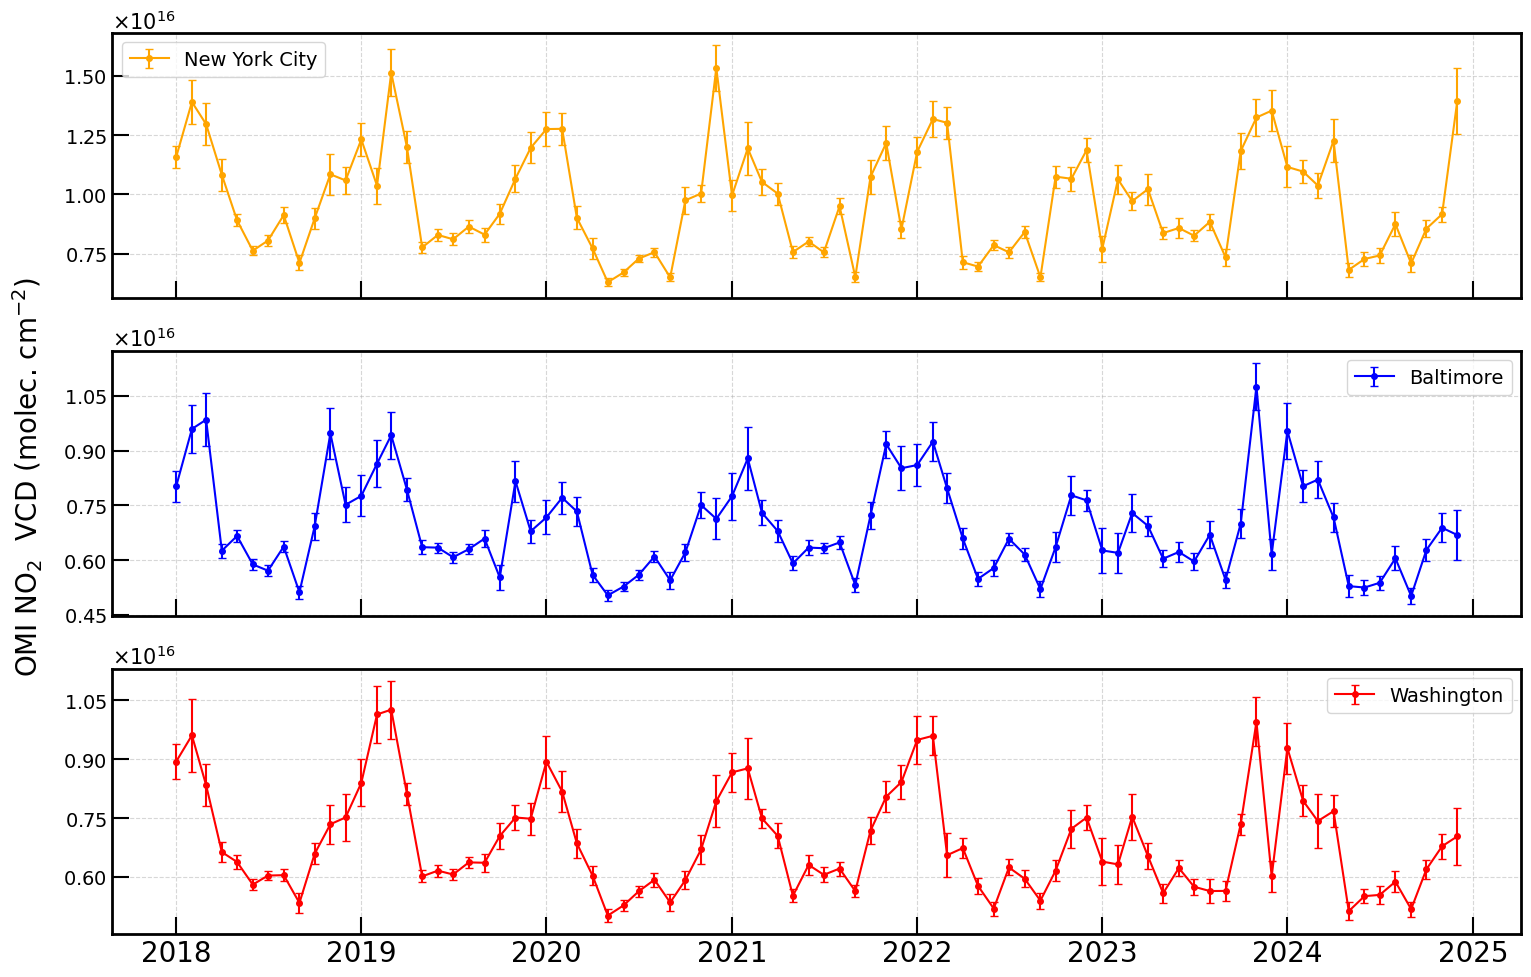

In [51]:
city_dfs = {
    "New York City": newyork_df,
    "Baltimore": baltimore_df,
    "Washington": washington_df,
}

fig, axes = plt.subplots(3, 1, figsize=(15, 10))  
col = 1
city_and_colors = {
    "New York City": "orange",
    "Baltimore": "blue",
    "Richmond": "purple",    
    "Washington": "red",
    "Philadelphia": "green",
}

for ax, (city_name, city_df) in zip(axes, city_dfs.items()):
    city_summary = city_df.groupby("year_month")["ColumnAmountNO2"].agg(["mean", lambda x: x.std() / (len(x) ** 0.5)]).reset_index()
    city_summary.rename(columns={"<lambda_0>": "stderr"}, inplace=True)
    city_summary["year_month"] = pd.to_datetime(city_summary["year_month"])
    color = city_and_colors[city_name]

    ax.errorbar(
        city_summary["year_month"],
        city_summary["mean"],
        yerr=city_summary["stderr"],
        fmt="o-", 
        capsize=3, 
        markersize=4,
        color=color,
        label=city_name
    )
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()
    if col != 3:
        plt.setp(ax.get_xticklabels(), visible=False)

    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2)
    ax.tick_params(which='minor', width=.8)
    ax.tick_params(which='major', width=1.5)
    ax.tick_params(which='major', length=12)
    ax.tick_params(which='minor', length=6.5)
    ax.tick_params(which = 'both', direction = 'in')
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='scientific', axis = 'y') 
    t = ax.yaxis.get_offset_text()
    t.set_size(15)
    col += 1

fig.text(-0.01, 0.512, 'OMI NO$_2$  VCD (molec. $\mathregular{cm^{-2}}$)', ha='center', va='center', rotation='vertical', fontsize = 20)
plt.subplots_adjust(bottom=0.1, hspace=-1, wspace=-0.3)  
plt.tight_layout()
plt.show()

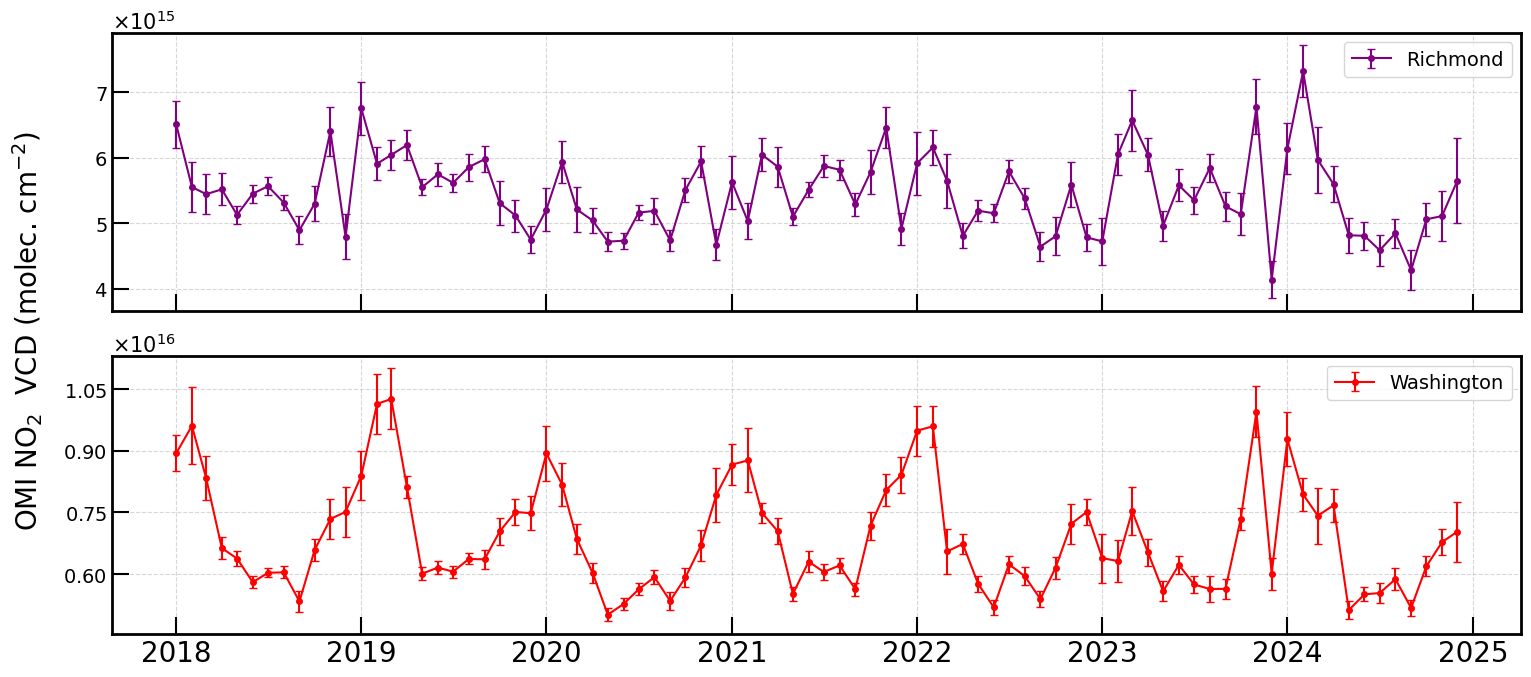

In [52]:
city_dfs = {
    "Richmond": richmond_df,
    "Washington": washington_df,
}
fig, axes = plt.subplots(2, 1, figsize=(15, 7))  
col = 1
city_and_colors = {
    "New York City": "orange",
    "Baltimore": "blue",
    "Richmond": "purple",    
    "Washington": "red",
    "Philadelphia": "green",
}

for ax, (city_name, city_df) in zip(axes, city_dfs.items()):
    city_summary = city_df.groupby("year_month")["ColumnAmountNO2"].agg(["mean", lambda x: x.std() / (len(x) ** 0.5)]).reset_index()
    city_summary.rename(columns={"<lambda_0>": "stderr"}, inplace=True)
    city_summary["year_month"] = pd.to_datetime(city_summary["year_month"])
    color = city_and_colors[city_name]

    ax.errorbar(
        city_summary["year_month"],
        city_summary["mean"],
        yerr=city_summary["stderr"],
        fmt="o-", 
        capsize=3, 
        markersize=4,
        color=color,
        label=city_name
    )
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()
    if col != 2:
        plt.setp(ax.get_xticklabels(), visible=False)

    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2)
    ax.tick_params(which='minor', width=.8)
    ax.tick_params(which='major', width=1.5)
    ax.tick_params(which='major', length=12)
    ax.tick_params(which='minor', length=6.5)
    ax.tick_params(which = 'both', direction = 'in')
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_major_formatter(formatter)
    ax.ticklabel_format(style='scientific', axis = 'y') 
    t = ax.yaxis.get_offset_text()
    t.set_size(15)
    col += 1

fig.text(-0.01, 0.512, 'OMI NO$_2$  VCD (molec. $\mathregular{cm^{-2}}$)', ha='center', va='center', rotation='vertical', fontsize = 20)
plt.subplots_adjust(bottom=0.1, hspace=-1, wspace=-0.3)  
plt.tight_layout()
plt.show()

In [53]:
weekday_averages = newyork_df.groupby("day_name")["ColumnAmountNO2"].mean().reset_index()
weekday_averages["day_name"] = pd.Categorical(weekday_averages["day_name"], 
                                              categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], 
                                              ordered=True)
weekday_averages = weekday_averages.sort_values("day_name")
weekday_averages

,day_name,ColumnAmountNO2
1,Monday,9.154677e+15
5,Tuesday,9.600606e+15
6,Wednesday,1.020544e+16
4,Thursday,9.652671e+15
0,Friday,1.045325e+16
2,Saturday,7.984666e+15
3,Sunday,7.734371e+15


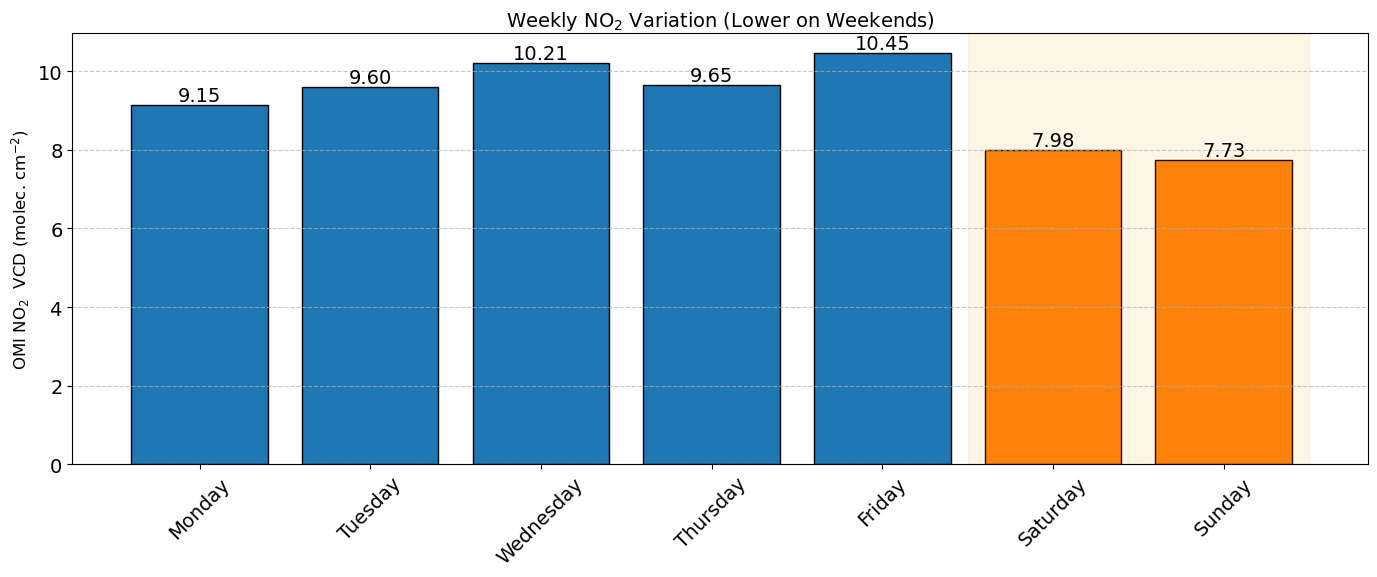

In [74]:
weekday_averages['is_weekend'] = weekday_averages['day_name'].isin(['Saturday', 'Sunday'])
colors = ['#1f77b4' if not weekend else '#ff7f0e' for weekend in weekday_averages['is_weekend']]

plt.figure(figsize=(14, 6))

bars = plt.bar(
    weekday_averages['day_name'],
    weekday_averages['ColumnAmountNO2'] / 1e15,  
    color=colors,
    edgecolor='black',
    linewidth=1
)

plt.title('Weekly NO$_2$ Variation (Lower on Weekends)', fontsize=14, pad=5)
plt.xlabel('', fontsize=12)
plt.ylabel('OMI NO$_2$  VCD (molec. $\mathregular{cm^{-2}}$)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.axvspan(4.5, 6.5, color='orange', alpha=0.1, label='Weekend') 
plt.legend().remove()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=14)
    
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

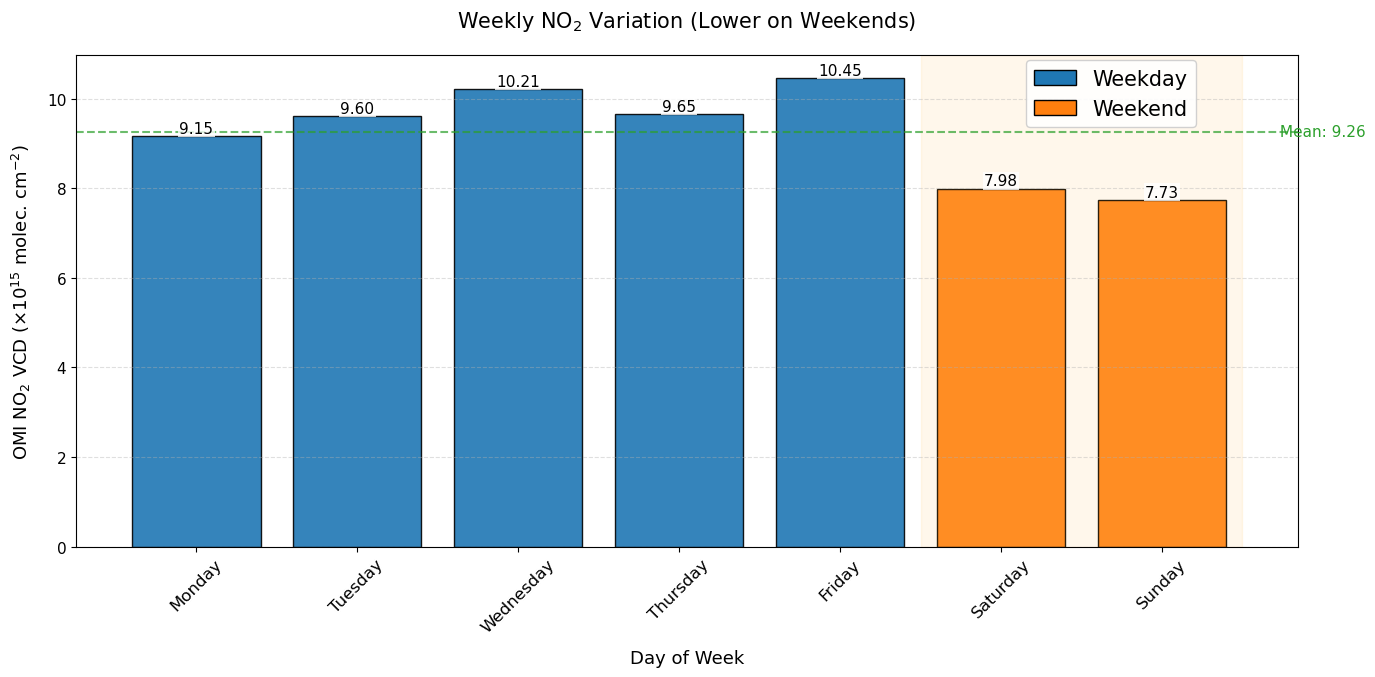

In [93]:
plt.figure(figsize=(14, 7))

colors = ['#1f77b4' if not weekend else '#ff7f0e' for weekend in weekday_averages['is_weekend']]
bars = plt.bar(
    weekday_averages['day_name'],
    weekday_averages['ColumnAmountNO2'] / 1e15,
    color=colors,
    edgecolor='black',
    linewidth=1,
    alpha=0.9
)

plt.title('Weekly NO$_2$ Variation (Lower on Weekends)', 
          fontsize=15, pad=20, fontweight='normal')
plt.xlabel('Day of Week', fontsize=13, labelpad=10)
plt.ylabel('OMI NO$_2$ VCD ($\\times10^{15}$ molec. $\mathregular{cm^{-2}}$)', 
           fontsize=13, labelpad=10)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=11)

plt.axvspan(4.5, 6.5, color='orange', alpha=0.08, label='Weekend')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=11,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))

weekday_patch = plt.Rectangle((0,0),1,1, fc='#1f77b4', edgecolor='black')
weekend_patch = plt.Rectangle((0,0),1,1, fc='#ff7f0e', edgecolor='black')
plt.legend([weekday_patch, weekend_patch], ['Weekday', 'Weekend'], 
           frameon=True, framealpha=0.9, fontsize=15, loc='upper right',
           bbox_to_anchor=(0.925, 1.01))

overall_mean = (weekday_averages['ColumnAmountNO2'].mean()) / 1e15
plt.axhline(y=overall_mean, color='#2ca02c', linestyle='--', linewidth=1.5, alpha=0.7)
plt.text(6.7, overall_mean, f' Mean: {overall_mean:.2f}', 
         va='center', ha='left', color='#2ca02c', fontsize=11)

plt.tight_layout()
plt.show()

In [55]:
def assign_season(month):
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

df1["season"] = df1["month"].apply(assign_season)

In [56]:
%%time

local_data = df1[df1.season=="DJF"].copy()
result = fishnet_x.sjoin(local_data, predicate = 'intersects')
fishnet_x["DJF"]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet_x['ID'])

CPU times: total: 1.66 s
Wall time: 5.74 s


In [57]:
%%time

local_data = df1[df1.season=="MAM"].copy()
result = fishnet_x.sjoin(local_data, predicate = 'intersects')
fishnet_x["MAM"]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet_x['ID'])

CPU times: total: 3.67 s
Wall time: 9.95 s


In [58]:
%%time

local_data = df1[df1.season=="JJA"].copy()
result = fishnet_x.sjoin(local_data, predicate = 'intersects')
fishnet_x["JJA"]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet_x['ID'])

CPU times: total: 3.72 s
Wall time: 14.1 s


In [59]:
%%time

local_data = df1[df1.season=="SON"].copy()
result = fishnet_x.sjoin(local_data, predicate = 'intersects')
fishnet_x["SON"]  = get_ordered_dict(dict(result.groupby('ID', dropna = False)['ColumnAmountNO2'].mean()), fishnet_x['ID'])

CPU times: total: 2.22 s
Wall time: 8.15 s


0it [00:00, ?it/s]

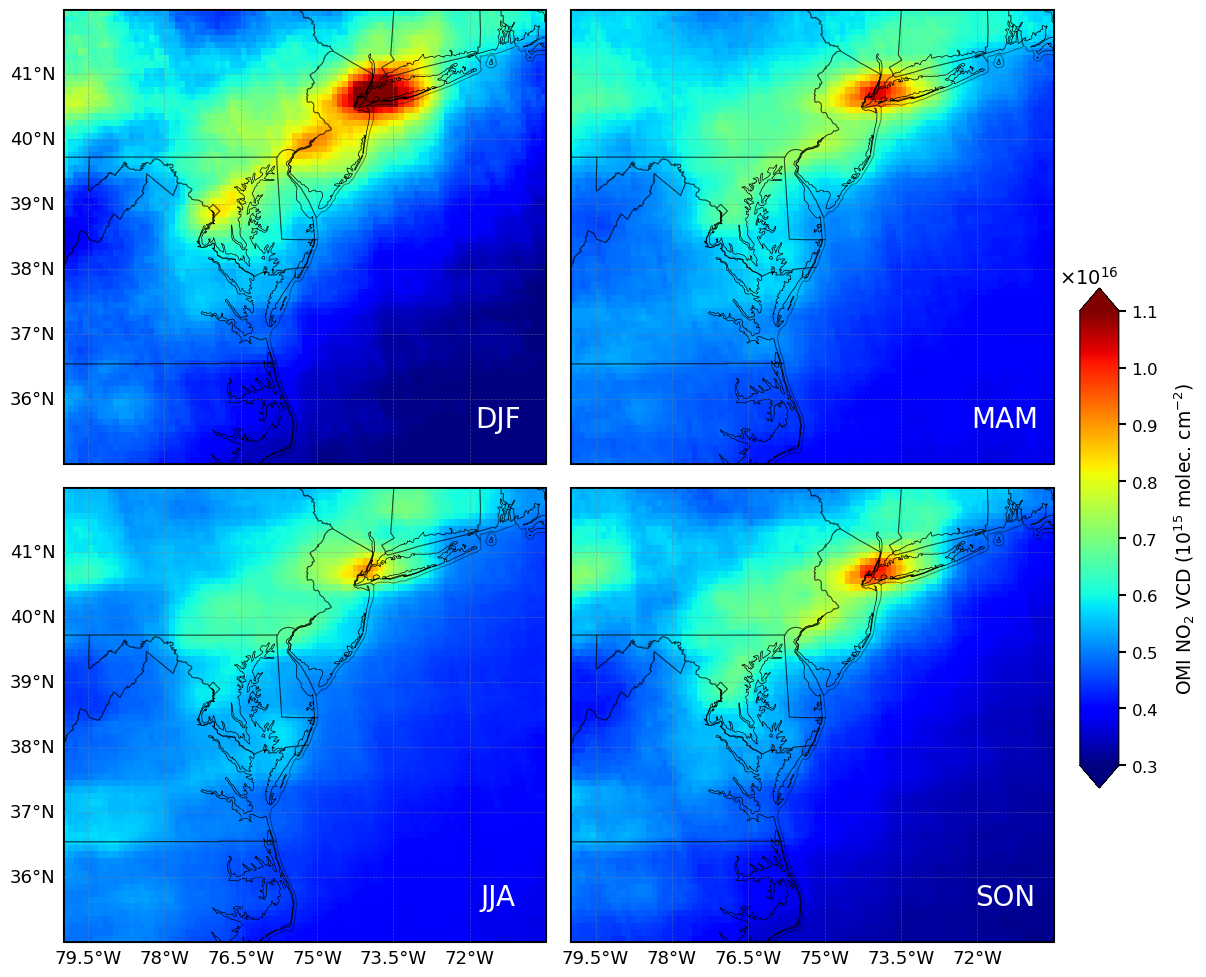

In [60]:
vmin = 3e+15
vmax = 11e+15
cmap = "jet"
alpha = 1

plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(2, 2, figsize=(13, 10), 
                        subplot_kw={"projection": ccrs.PlateCarree()})
columns = ['DJF', 'MAM', "JJA", "SON"]
current_col = 0

for ax, col in tqdm(zip(axes.ravel(), columns)):
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    if current_col not in [0, 2]:
        gl.left_labels = False

    if current_col not in [2, 3]:
        gl.bottom_labels = False
    
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    
    bounding_box.geometry.boundary.plot(ax=ax, color='black', linewidth=2, alpha=1, transform=ccrs.PlateCarree())
    us_states.geometry.boundary.plot(ax=ax, color='black', linewidth=0.75, alpha=0.45, transform=ccrs.PlateCarree())

    fishnet_x.plot(ax=ax, column=col, alpha=alpha, linewidth=0, edgecolor=None, cmap=cmap,
                   missing_kwds=dict(color='grey', label='No Data'), vmin=vmin, vmax=vmax, legend=False)
    
    ax.annotate(col, xy=(0.9, 0.1), xycoords='axes fraction', fontsize=20, ha='center', va='center', color="white", fontweight="normal")

    ax.tick_params(labelsize=20)
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black') 
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_lw(2) 
    ax.tick_params(which='both', width=3)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=6)
    ax.tick_params(which = 'both', direction = 'in')
    current_col += 1

cax = fig.add_axes([0.905, 0.2, 0.03, 0.5])  
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation='vertical', extend='both')
cbar.set_label('OMI NO$_2$ VCD ($10^{15}$ molec. $\mathregular{cm^{-2}}$)', 
               fontsize=13.5, labelpad=10, fontweight='normal')
cbar.ax.tick_params(length=5, width=1.5, which="major", direction='out', labelsize=12)
cbar.set_alpha(alpha)
cbar.draw_all()
cbar.formatter.set_useMathText(True)
plt.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=-0.315)  
plt.show()  

In [61]:
newyork_df["season"] = newyork_df["month"].apply(assign_season)

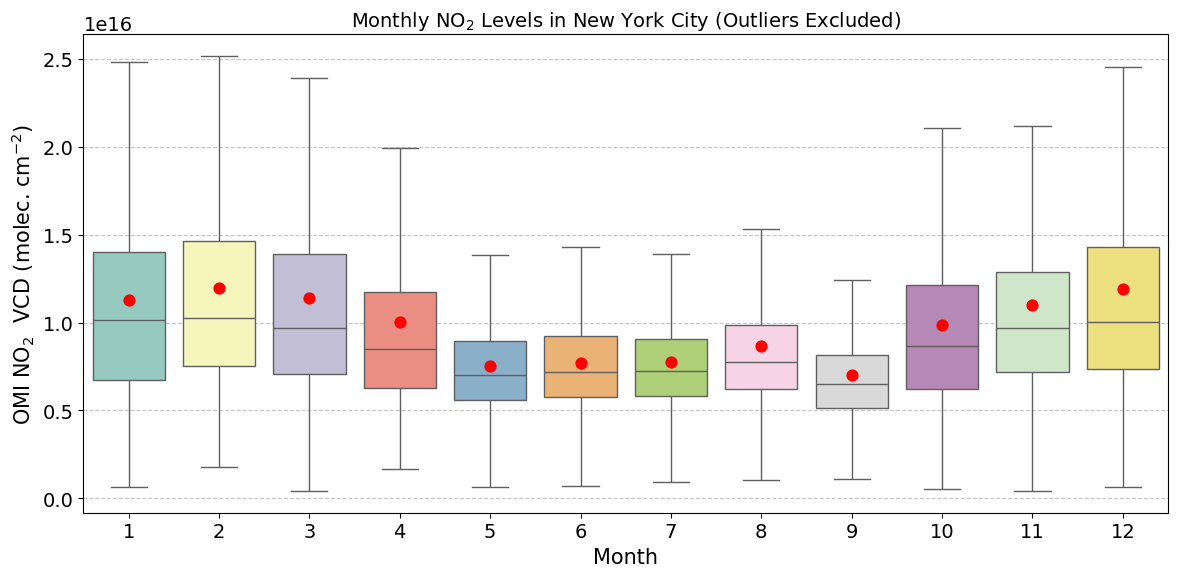

In [65]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=newyork_df, x="month", y="ColumnAmountNO2", palette="Set3", showfliers=False)
sns.pointplot(data=newyork_df, x="month", y="ColumnAmountNO2", color="red", markers="o", linestyles="", ci=None, estimator=np.mean)
plt.title("Monthly NO$_2$ Levels in New York City (Outliers Excluded)", fontsize=14)
plt.xlabel("Month", fontsize=15)
plt.ylabel('OMI NO$_2$  VCD (molec. $\mathregular{cm^{-2}}$)', fontsize=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
ax.tick_params(labelsize=20)
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_lw(2) 
ax.tick_params(which='both', width=3)
ax.tick_params(which='major', length=6)
ax.grid(True, linestyle="--", alpha=0.5)
ax.tick_params(which='minor', length=6)
ax.tick_params(which = 'both', direction = 'in')
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='scientific', axis = 'y') 
t = ax.yaxis.get_offset_text()
t.set_size(15)
plt.tight_layout()
plt.show()